In [ ]:
import keras
import tensorflow as tf

from keras import layers
from keras import ops
import matplotlib.pyplot as plt
from typing import Optional, Dict, Any
import os
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

In [ ]:
dataset = tf.keras.utils.image_dataset_from_directory('petfaces', label_mode=None, image_size=(64,64), batch_size=8)
dataset = dataset.map(lambda x: x/255.0)

2025-04-09 08:31:00.847415: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-04-09 08:31:00.847449: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-04-09 08:31:00.847461: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-04-09 08:31:00.847479: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-09 08:31:00.847492: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


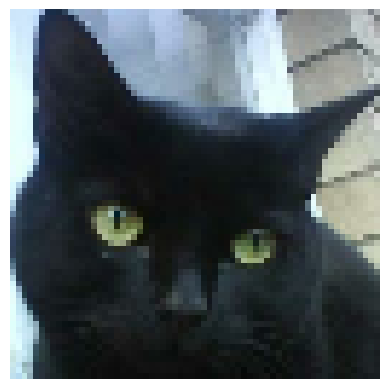

In [4]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

### Дискриминатор

In [ ]:
# Создаем дискриминатор - модель, которая отличает реальные изображения от сгенерированных
discriminator = keras.Sequential(
    [
        # Входной слой: изображения размером 64x64 пикселя с 3 каналами (RGB)
        keras.Input(shape=(64, 64, 3)),
        
        # Первый сверточный слой:
        # - 64 фильтра
        # - размер ядра 4x4
        # - шаг 2 (уменьшение размерности в 2 раза)
        # - padding="same" (сохранение размеров с нулевым заполнением)
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        # Активация LeakyReLU (позволяет небольшим отрицательным значениям проходить)
        layers.LeakyReLU(negative_slope=0.2),
        
        # Второй сверточный слой с 128 фильтрами
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        
        # Третий сверточный слой с 128 фильтрами
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        
        # Преобразуем 3D-тенсор в 1D-вектор для полносвязного слоя
        layers.Flatten(),
        
        # Регуляризация: отключаем 20% нейронов для предотвращения переобучения
        layers.Dropout(0.2),
        
        # Выходной слой с 1 нейроном и сигмоидной активацией 
        # (вероятность, что изображение настоящее)
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",  # Имя модели для удобства
)

# Выводим информацию о модели, включая количество обучаемых параметров
discriminator.summary(show_trainable=True)

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ conv2d (Conv2D)             │ (None, 32, 32, 64)    │      3,136 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ leaky_re_lu (LeakyReLU)     │ (None, 32, 32, 64)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_1 (Conv2D)           │ (None, 16, 16, 128)   │    131,200 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ leaky_re_lu_1 (LeakyReLU)   │ (None, 16, 16, 128)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_2 (Conv2D)           │ (None, 8, 8, 128)     │    262,272 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ leaky_re_lu_2 (LeakyReLU)   │ (None, 8, 8, 128)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten (Flatten)           │ (None, 8192)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 8192)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 1)             │      8,193 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 404,801 (1.54 MB)

 Trainable params: 404,801 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

### Генератор

In [ ]:
# Размерность латентного пространства (размер входного шумового вектора)
latent_dim = 128

# Создаем генератор - модель, которая преобразует случайный шум в изображения
generator = keras.Sequential(
    [
        # Входной слой: принимает вектор шума размерности latent_dim
        keras.Input(shape=(latent_dim,)),
        
        # Полносвязный слой, который преобразует входной вектор в тензор,
        # достаточный для формирования начального изображения 8x8 с 128 каналами
        # (8*8*128 = 8192 нейрона)
        layers.Dense(8 * 8 * 128),
        
        # Преобразуем плоский вектор в 3D-тенсор размером 8x8x128
        # (подготовка к операциям транспонированной свертки)
        layers.Reshape((8, 8, 128)),
        
        # Первый слой транспонированной свертки (обратной свертки):
        # - 128 фильтров
        # - ядро 4x4
        # - шаг 2 (увеличивает размерность в 2 раза: 8x8 -> 16x16)
        # - padding="same" (сохраняет границы)
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        # Активация LeakyReLU (позволяет модели лучше обучаться)
        layers.LeakyReLU(negative_slope=0.2),
        
        # Второй слой транспонированной свертки:
        # - 256 фильтров
        # - увеличивает размерность 16x16 -> 32x32
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        
        # Третий слой транспонированной свертки:
        # - 512 фильтров
        # - увеличивает размерность 32x32 -> 64x64
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        
        # Финальный сверточный слой:
        # - 3 фильтра (для RGB-каналов)
        # - ядро 5x5
        # - сигмоидная активация (приводит значения к диапазону [0,1] - пиксели изображения)
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",  # Имя модели для удобства
)

# Выводим информацию о модели, включая количество обучаемых параметров
generator.summary(show_trainable=True)

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ dense_1 (Dense)             │ (None, 8192)          │  1,056,768 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ reshape (Reshape)           │ (None, 8, 8, 128)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_transpose            │ (None, 16, 16, 128)   │    262,272 │   Y   │
│ (Conv2DTranspose)           │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ leaky_re_lu_3 (LeakyReLU)   │ (None, 16, 16, 128)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_transpose_1          │ (None, 32, 32, 256)   │    524,544 │   Y   │
│ (Conv2DTranspose)           │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ leaky_re_lu_4 (LeakyReLU)   │ (None, 32, 32, 256)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_transpose_2          │ (None, 64, 64, 512)   │  2,097,664 │   Y   │
│ (Conv2DTranspose)           │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ leaky_re_lu_5 (LeakyReLU)   │ (None, 64, 64, 512)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_3 (Conv2D)           │ (None, 64, 64, 3)     │     38,403 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 3,979,651 (15.18 MB)

 Trainable params: 3,979,651 (15.18 MB)

 Non-trainable params: 0 (0.00 B)

# Обучение

In [ ]:
"""
Описание программного кода:
----------------------------
Данный код реализует генеративно-состязательную сеть (GAN) с использованием библиотеки Keras.
Класс `GAN` представляет собой модель GAN, которая состоит из двух подмоделей: 
генератора (generator) и дискриминатора (discriminator). 
Класс `GANMonitor` используется для мониторинга процесса обучения GAN и сохранения 
генерируемых изображений в конце каждой эпохи.

Функциональное назначение:
----------------------------
1. Класс `GAN` отвечает за обучение генератора и дискриминатора, а также за вычисление потерь.
2. Класс `GANMonitor` сохраняет изображения, сгенерированные генератором, в файловой системе 
   для визуализации прогресса обучения.
"""


class GAN(keras.Model):
    """
    Description:
    ---------------
        Реализация генеративно-состязательной сети (GAN).

    Args:
    ---------------
        discriminator: Модель дискриминатора.
        generator: Модель генератора.
        latent_dim: Размерность скрытого пространства.

    Returns:
    ---------------
        Объект класса GAN.

    Raises:
    ---------------
        ValueError: Если переданные модели или параметры некорректны.

    Examples:
    ---------------
        >>> discriminator = keras.Sequential([...])
        >>> generator = keras.Sequential([...])
        >>> gan = GAN(discriminator, generator, latent_dim=100)
    """

    def __init__(self, discriminator: keras.Model, generator: keras.Model, latent_dim: int):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)

    def compile(
        self,
        d_optimizer: tf.keras.optimizers.Optimizer,
        g_optimizer: tf.keras.optimizers.Optimizer,
        loss_fn: tf.keras.losses.Loss,
    ):
        """
        Description:
        ---------------
            Компиляция модели GAN с оптимизаторами и функцией потерь.

        Args:
        ---------------
            d_optimizer: Оптимизатор для дискриминатора.
            g_optimizer: Оптимизатор для генератора.
            loss_fn: Функция потерь.

        Returns:
        ---------------
            None.

        Raises:
        ---------------
            ValueError: Если переданные оптимизаторы или функция потерь некорректны.
        """
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self) -> list:
        """
        Description:
        ---------------
            Возвращает метрики для мониторинга.

        Returns:
        ---------------
            Список метрик.
        """
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images: tf.Tensor) -> Dict[str, float]:
        """
        Description:
        ---------------
            Один шаг обучения GAN.

        Args:
        ---------------
            real_images: Тензор реальных изображений.

        Returns:
        ---------------
            Словарь с потерями дискриминатора и генератора.

        Raises:
        ---------------
            ValueError: Если входные данные некорректны.
        """
        # Генерация случайных точек в скрытом пространстве
        batch_size = ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        # Декодирование в фейковые изображения
        generated_images = self.generator(random_latent_vectors)

        # Объединение реальных и фейковых изображений
        combined_images = ops.concatenate([generated_images, real_images], axis=0)

        # Создание меток для различения реальных и фейковых изображений
        labels = ops.concatenate(
            [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
        )
        # Добавление шума к меткам (важный трюк!)
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Обучение дискриминатора
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Генерация случайных точек в скрытом пространстве
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        # Создание меток, указывающих на "реальные" изображения
        misleading_labels = ops.zeros((batch_size, 1))

        # Обучение генератора (веса дискриминатора не обновляются)
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Обновление метрик
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


class GANMonitor(keras.callbacks.Callback):
    """
    Description:
    ---------------
        Класс для мониторинга процесса обучения GAN.

    Args:
    ---------------
        num_img: Количество изображений для генерации.
        latent_dim: Размерность скрытого пространства.

    Returns:
    ---------------
        None.

    Raises:
    ---------------
        ValueError: Если переданные параметры некорректны.
    """

    def __init__(self, num_img: int = 3, latent_dim: int = 128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(42)

    def on_epoch_end(self, epoch: int, logs: Optional[Dict[str, Any]] = None):
        """
        Description:
        ---------------
            Сохранение сгенерированных изображений в конце каждой эпохи.

        Args:
        ---------------
            epoch: Номер текущей эпохи.
            logs: Логи обучения (необязательный параметр).

        Returns:
        ---------------
            None.

        Raises:
        ---------------
            IOError: Если возникают проблемы с сохранением изображений.
        """
        random_latent_vectors = keras.random.normal(
            shape=(self.num_img, self.latent_dim), seed=self.seed_generator
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save("./generated_imgs_by_gan/generated_img_%03d_%d.png" % (epoch, i))

In [ ]:
# Количество эпох обучения
epochs = 260

# Создаем GAN модель, объединяя генератор и дискриминатор
# - discriminator: модель, отличающая реальные изображения от сгенерированных
# - generator: модель, создающая изображения из случайного шума
# - latent_dim: размерность латентного пространства (пространства шума)
gan = GAN(discriminator=discriminator, 
          generator=generator, 
          latent_dim=latent_dim)

# Компилируем модель с настройками обучения:
# - d_optimizer: оптимизатор для дискриминатора (Adam с маленьким learning rate)
# - g_optimizer: оптимизатор для генератора (Adam с таким же learning rate)
# - loss_fn: функция потерь (бинарная кросс-энтропия - стандарт для GAN)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # Малый LR для стабильного обучения
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # Аналогичный LR для генератора
    loss_fn=keras.losses.BinaryCrossentropy(),                # Стандартная функция потерь для GAN
)

# Запускаем процесс обучения:
# - dataset: набор данных для обучения
# - epochs: количество эпох
# - callbacks: список колбэков (в данном случае мониторинг результатов)
gan.fit(
    dataset,                                                  # Тренировочный датасет с изображениями
    epochs=epochs,                                            # Количество проходов по всему датасету
    callbacks=[GANMonitor(num_img=3, latent_dim=latent_dim)]  # Колбэк для визуализации прогресса
    # (сохраняет 3 сгенерированных изображения после каждой эпохи)
)

Epoch 1/200


402/402 ━━━━━━━━━━━━━━━━━━━━ 97s 194ms/step - d_loss: 0.7070 - g_loss: 0.8486
Epoch 2/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 72s 178ms/step - d_loss: 0.6943 - g_loss: 0.9270
Epoch 3/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 72s 179ms/step - d_loss: 0.7015 - g_loss: 0.8555
Epoch 4/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 72s 179ms/step - d_loss: 0.6879 - g_loss: 0.9515
Epoch 5/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 72s 179ms/step - d_loss: 0.6667 - g_loss: 0.8929
Epoch 6/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 72s 178ms/step - d_loss: 0.6720 - g_loss: 0.8570
Epoch 7/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 75s 186ms/step - d_loss: 0.7176 - g_loss: 0.9121
Epoch 8/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 72s 178ms/step - d_loss: 0.6966 - g_loss: 0.8228
Epoch 9/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 72s 180ms/step - d_loss: 0.7048 - g_loss: 0.9128
Epoch 10/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 79s 196ms/step - d_loss: 0.6631 - g_loss: 0.8951
Epoch 11/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 72s 180ms/step - d_loss: 0.6994 - g_loss: 0.9089
Epoch 12/200
402/402

In [ ]:
gan.save("./models/gan.keras")

/Users/Verbasik/Desktop/ai-lab-m2-convolutional-networks-1985Viacheslav-main/.venv/lib/python3.11/site-packages/keras/src/saving/saving_api.py:100: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data. saving_lib.save_model(model, filepath)


### Пример генерации

In [ ]:
gan = tf.keras.models.load_model("./models/gan.keras")

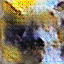

In [57]:
vect = tf.keras.random.normal(
    shape=(1,128)
)
gen_img = gan.generator(vect)*255
tf.keras.utils.array_to_img(gen_img[0])

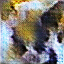

In [78]:
vect = tf.keras.random.normal(
    shape=(1,128)
)
gen_img = gan.generator(vect)*255
tf.keras.utils.array_to_img(gen_img[0])

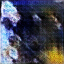

In [345]:
vect = tf.keras.random.normal(
    shape=(1,128)
)
gen_img = gan.generator(vect)*255
tf.keras.utils.array_to_img(gen_img[0])